<a href="https://colab.research.google.com/github/Code-Trees/CNN/blob/master/CIFAR10_dialated_conv_depthwise_sep_Bn_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
# Requirement Check

In [156]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info) 

Tue Feb 15 07:50:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   1370MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [157]:
import os

!pip install opencv-python
!pip install -U albumentations
!pip install opencv-python-headless==4.5.2.52
!pip install Pillow
!pip install rf_calc

In [158]:
import warnings
warnings.filterwarnings('ignore')
%autosave 5

Autosaving every 5 seconds


In [159]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 10

Autosaving every 10 seconds


In [160]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms,datasets

import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import seaborn as sns
import gc

import albumentations as A
from albumentations.augmentations.geometric.resize import Resize
from albumentations.pytorch.transforms import ToTensorV2

In [161]:
# we will use the CIFAR10 dataset. It has the classes:
# ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
# The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [162]:
from tqdm import tqdm
from rf_calc import receptive_field

GPU Cleaner

In [163]:
def clean_gpu():
    """Considering we have GPUs"""

    gc.collect()
    torch.cuda.empty_cache()
    return None

Data Loading 

In [164]:
def get_data(train_transform_composes =None ,test_transform_composes =None):
    """We can compose customs , else the default is tensors 
    """
    train = datasets.CIFAR10(root= './',download = True, train = True,transform = train_transform_composes)
    
    test = datasets.CIFAR10(root= './',download = True, train = False ,transform = train_transform_composes)

    return train,test 

EDA With Experiments

In [165]:
def plot_unique_images(data_set,labels = None):
    img_data = data_set.data
    target = data_set.targets.copy()

    fig = plt.figure(figsize=(30,30))
    count = 1
    unique_images_index = [random.choice(np.where(np.array(target) == search)[0]) for search in list(set(target))]

    for image_index in unique_images_index:
        n= image_index
        ax = fig.add_subplot(1,10,count)
        _=plt.imshow(img_data[n])
        try:
            _=plt.title(f"label :{labels[target[n]]} idx:{n}")
        except:
            _=plt.title(f"idx:{n} Label: {target[n]}")
        _ = plt.autoscale()
        _= fig.tight_layout(pad =1)
        count+= 1
        if count>=len(target):
            break
    plt.show()


In [166]:
def get_data_stats(dataset_train,dataset_test = None,img_norm_typ ='train',plot = False):
    MEAN = []
    STD = []
    VAR = []
    if img_norm_typ == 'train':
        fig = plt.figure(figsize=(15,5))
        for i in range(0,dataset_train.data.shape[len(dataset_train.data.shape)-1]):
            scale = dataset_train.data[:,:,:,i]/dataset_train.data[:,:,:,i].max()
            MEAN.append(scale.mean())
            STD.append(scale.std())
            VAR.append(scale.var())
            if plot == True:
                ax = fig.add_subplot(1,3,i+1)
                _=sns.histplot(scale.reshape(-1) )
                _=plt.title(f"label :{'Train' if dataset_train.train else 'Test' } Channel:{i+1}")
                _= plt.xlabel(f"Mean:{round(MEAN[i],3)}, std:{round(STD[i],3)}, var:{round(VAR[i],3)}")
                _ = plt.autoscale()
                _= fig.tight_layout(pad =1)
        # plt.show()
        # print(f" For {'Train' if dataset_train.train else 'Test'} data, Mean: {MEAN} || Variance: {VAR} || Standard Dev: {STD} || Data Dim: {dataset_train.data.shape}")

    elif img_norm_typ == 'train+test':
        fig = plt.figure(figsize=(10,5))
        mega_data  =np.append(dataset_train.data, dataset_test.data, 0)
        for i in range(0,dataset_train.data.shape[len(dataset_train.data.shape)-1]):
            scale = mega_data[:,:,:,i]/mega_data[:,:,:,i].max()
            MEAN.append(scale.mean())
            STD.append(scale.std())
            VAR.append(scale.var())
            if plot == True:
                ax = fig.add_subplot(1,3,i+1)
                _=sns.histplot(scale.reshape(-1))
                _=plt.title(f"label :{'Train' if dataset_train.train else 'Test' } Channel:{i+1}")
                _= plt.xlabel(f"Mean:{round(MEAN[i],3)},std:{round(STD[i],3)},var:{round(VAR[i],3)}")
                _ = plt.autoscale()
                _= fig.tight_layout(pad =1)
        # print(f"For {'Train' if dataset_train.train else 'Test'} data, Mean: {MEAN} || Variance: {VAR} || Standard Dev: {STD} || for {mega_data.shape} Dim")
    return tuple(MEAN),tuple(STD)

Files already downloaded and verified
Files already downloaded and verified
Train Shape: (50000, 32, 32, 3) Test Shape: (10000, 32, 32, 3) 



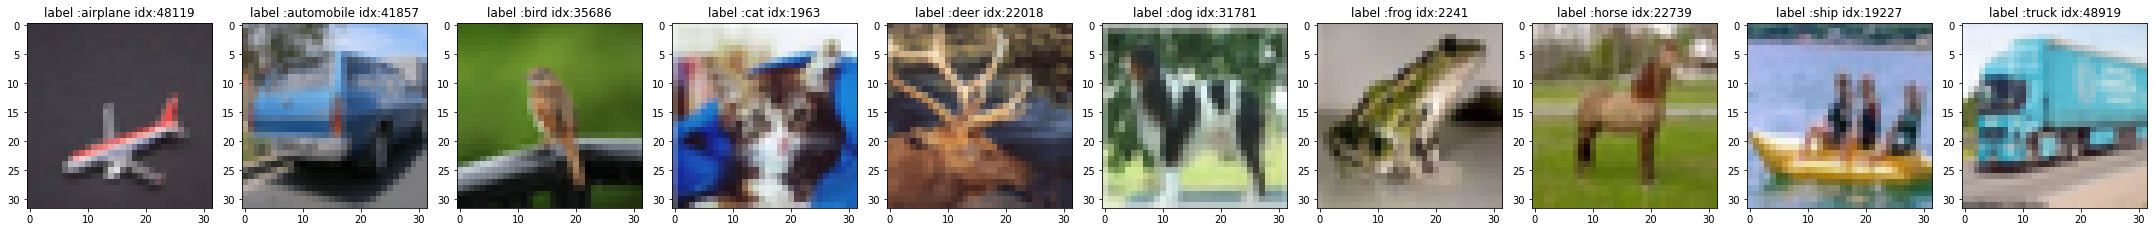

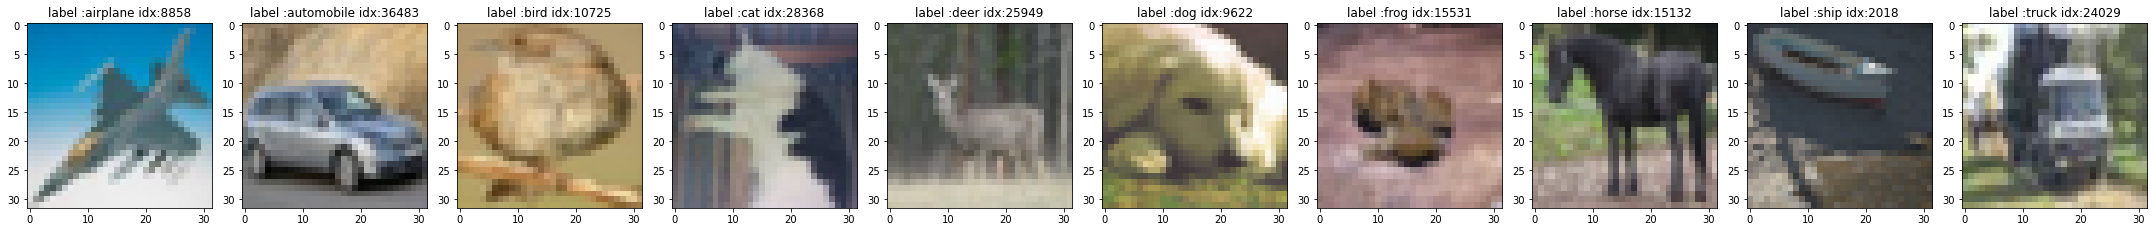

In [167]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
train,test = get_data()
print(f"Train Shape: {train.data.shape} Test Shape: {test.data.shape} \n")
plot_unique_images(train,labels =labels)
plot_unique_images(train,labels =labels)

In [168]:
#Calculating mean and veriance and std

In [169]:
# img_norm_typ  can be 'train' and 'train+test
mean,std  = get_data_stats(train,test,img_norm_typ ='train+test',plot = False)
print(f"Mean: {mean} \nSTD: {std}")

Mean: (0.49186877885008395, 0.48265390516493006, 0.44717727749693653) 
STD: (0.2469712143255279, 0.24338893940434994, 0.2615925905215076)


<Figure size 720x360 with 0 Axes>

Data Transform Compose

In [170]:
# Base Normalization
train_transform =A.Compose([A.Resize(32,32),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                            ToTensorV2(transpose_mask =False),
                            ])      
test_transform = A.Compose([A.Resize(32,32),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                            ToTensorV2(transpose_mask =False,),
                            ])

In [171]:
# Advanced Normalization
train_transform =A.Compose([A.Resize(32,32),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                             A.ShiftScaleRotate(always_apply=False),
                             A.CoarseDropout(always_apply = False,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                            ToTensorV2(transpose_mask =False),
                             ])      
test_transform = A.Compose([A.Resize(32,32),
                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                           ToTensorV2(transpose_mask =False), ])

numpy.ndarray

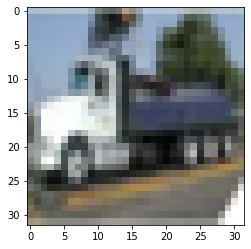

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before(32, 32, 3)
Aftertorch.Size([3, 32, 32])


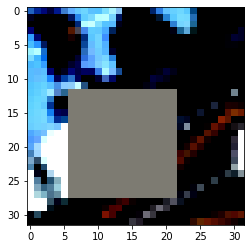

In [172]:
t = train.data
type(t[10])
a = t[np.random.randint(0,50000)]
_ = plt.imshow(a)
_ = plt.show()
print(f"Before{a.shape}")
# _ = plt.subplots(figsize = (5,5))
a = train_transform(image = a)["image"]
print(f"After{a.shape}")
_ = plt.imshow(np.transpose(a,(1,2,0)))
# _ = plt.imshow(a)

_ = plt.show()

Albumentation Compose

In [173]:
class AlbumDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = train.data
        self.label = train.targets
        self.transform = transform

    def __len__(self):
        return (len(self.train))

    def __getitem__(self, idx):
        image = self.train[idx]
        image = np.array(image)
        # image = image.fromarray(image).convert('RGB')
        # image = np.asarray(image).astype(np.unit8)
        if self.transform:
            aug_image = self.transform(image= image)["image"]
        aug_image = torch.tensor(aug_image,dtype =torch.float)
        return aug_image,self.label[idx]

Custom Network Normalization 

In [174]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)


def Normalize(norm_type,num_features,n_group=2):
    if norm_type == 'bn':
        return nn.BatchNorm2d(num_features = num_features)

    elif norm_type =='gn':
        return nn.GroupNorm(num_groups=n_group ,num_channels=num_features)
    
    elif norm_type =='ln':
        return nn.GroupNorm(num_groups =1, num_channels=num_features)

    elif norm_type == 'gbn':
        return  GhostBatchNorm(num_features, num_splits=4, weight=False)
        
    else:
        print ('Invalid norm Parameter, Providing Default as BN ')
        return nn.BatchNorm2d(num_features = num_features,)

Custom Convolution Blocks

In [175]:
class Depthwise_sep_conv(nn.Module):
    def __init__(self,in_channels,out_channels,dropout_val=0.1,norm_type = 'bn',stride = 1,padding = 1):
        super(Depthwise_sep_conv,self).__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.dropout_val = dropout_val
        self.norm_type = norm_type
        self.padding = padding 

        self.deptwiseseperable = nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels,kernel_size =(3,3), stride = self.stride,padding = self.padding,groups = self.in_channels, bias = False)
        self.pointwise = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,kernel_size =(1,1), stride =1, bias = False)
        self.norm = Normalize(norm_type = self.norm_type ,num_features= self.out_channels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(p = self.dropout_val)
    
    def forward(self,x):
        x = self.deptwiseseperable(x)
        x = self.pointwise(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

In [176]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride,padding,kernel_size=(3,3),norm_type = 'bn' ,dropout_val = 0,dilation = 1):
        super(ConvBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride=stride
        self.padding= padding
        self.kernel_size=kernel_size
        self.norm_type = norm_type
        self.dropout_val = dropout_val
        self.dilation = dilation

        self.conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,kernel_size=self.kernel_size,stride =self.stride,padding = self.padding,dilation =self.dilation ,bias = False)
        self.norm = Normalize(norm_type = self.norm_type ,num_features= self.out_channels)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(p = self.dropout_val)

    def forward(self,x):
        x = self.relu(self.norm(self.conv(x)))
        x= self.drop(x)
        return x

Model Building

In [177]:
class Cifar10Net1(nn.Module):
    def __init__(self,dropout_val = 0,norm_type = 'bn'):
        super(Cifar10Net1,self).__init__()
        self.norm_type = norm_type
        self.drop = dropout_val

        self.block1 = nn.Sequential(
            ConvBlock(in_channels=3,out_channels=8,kernel_size = (3,3),stride = 1, padding = 0,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=8,out_channels=16,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=16,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )
        
        self.pool1 =ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 2, padding = 1,norm_type = self.norm_type,dropout_val= self.drop)


        self.block2 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=16,kernel_size = (1,1),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            Depthwise_sep_conv(in_channels=16,out_channels=32,dropout_val=self.drop,norm_type = self.norm_type,stride = 1,padding = 1),
            Depthwise_sep_conv(in_channels=32,out_channels=64,dropout_val=self.drop,norm_type = self.norm_type,stride = 1,padding = 1),
            # ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )

        self.pool2 = ConvBlock(in_channels=64,out_channels=64,kernel_size = (3,3),stride = 2, padding = 0,norm_type = self.norm_type,dropout_val= self.drop)
        
        self.block3 = nn.Sequential(
            ConvBlock(in_channels=64,out_channels=32,kernel_size = (1,1),stride = 1, padding =1,norm_type = self.norm_type,dropout_val= self.drop),
            Depthwise_sep_conv(in_channels=32,out_channels=64,dropout_val=self.drop,norm_type = self.norm_type,stride = 1,padding =1),
            Depthwise_sep_conv(in_channels=64,out_channels=128,dropout_val=self.drop,norm_type = self.norm_type,stride = 1,padding =1),
            )

        self.conv_block1 = ConvBlock(in_channels=128,out_channels=32,kernel_size = (1,1),stride = 1, padding =0,norm_type = self.norm_type,dropout_val= self.drop)
        self.conv_block2 = ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding =0,norm_type = self.norm_type,dropout_val= self.drop,dilation =2)
        self.conv_block3 = ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding =0,norm_type = self.norm_type,dropout_val= self.drop,dilation =2)

        # self.conv_block1 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size = (1,1),stride = 1, padding =0,bias= False)
        # self.conv_block2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding =0,dilation =2,bias= False)
        self.conv_block3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding =0,bias= False)
        
        
        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1,1))
        # self.GAP = nn.AvgPool2d(kernel_size = (5,5))
        self.linear = nn.Linear(in_features =64 ,out_features = 10)
        # self.conv_block4 = nn.Conv2d(in_channels=64,out_channels=10,kernel_size = (3,3),stride = 1, padding =0)
        # self.conv_block5 = nn.Conv2d(in_channels=64,out_channels=10,kernel_size = (1,1),stride = 1, padding =0)
        # self.conv_block4 = nn.Conv2d(in_channels=32,out_channels=10,kernel_size = (1,1),stride = 1, padding =0,bias= False)



    def forward(self,x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.GAP(x)
        # x = self.conv_block4(x)
        # x = self.conv_block5(x)
        # return x
        x = x.view(-1,64)
        x = self.linear(x)
        return F.log_softmax(x,dim = -1)

In [178]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
model = Cifar10Net1(norm_type='bn',dropout_val=0.01).to(device)
rf_df = receptive_field(model,32)
summary(model,input_size=(3,32,32))

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | NO        |        1 | 32*32            | 30*30             | 3*3               |
|  1 | 3*3           | 1         |        1 | 30*30            | 30*30             | 5*5               |
|  2 | 3*3           | 1         |        1 | 30*30            | 30*30             | 7*7               |
|  3 | 3*3           | 1         |        2 | 30*30            | 15*15             | 9*9               |
|  4 | 1*1           | 1         |        1 | 15*15            | 17*17             | 9*9               |
|  5 | 3*3           | 1         |        1 | 17*17            | 17*17             | 13*13             |
|  6 | 1*1           | NO        |        1 | 17*17   

Model Checks

In [179]:
# device = 'cuda' if torch.cuda.is_available() else "cpu"
# model = Cifar10Net(norm_type='bn',dropout_val=0.01).to(device)
# rf_df = receptive_field(model,32)
# summary(model,input_size=(3,32,32))

Loss Function and Optimizers

In [180]:
def get_optimizer(model_obj,loss_type=None,scheduler = False):
    loss_type= str(loss_type).upper()
    parameters = model_obj.parameters()
    if loss_type  == 'L2' :
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9,weight_decay= 0.001)
    else:
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9)
    if scheduler == True:
        scheduler = StepLR(optimizer,step_size = 20,gamma = 0.1)
        return optimizer,scheduler
    else:
        return optimizer,_


#L1 Loss

def L1_loss(model_obj,loss):
        
    l1 = 0
    lambda_l1 = 0.0001
    for p in model_obj.parameters():
        l1 = l1+p.abs().sum()
        loss = loss+ lambda_l1* l1
    return loss


Model Performance Visualizer

In [181]:

def plot_acc_loss(typ ,train_acc,train_losses,test_acc,test_losses):
    fig, axs = plt.subplots(1,2,figsize = (20,5))
    # print ('Accuracy model on  ', typ)
    plt.autoscale()
    axs[0].plot(train_acc,color = 'red')
    axs[0].plot(test_acc,color = 'green')
    title = 'Training/testing accuracy'
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc','test acc'], loc='best')
       
    axs[1].plot(train_losses,color = 'red')
    axs[1].plot(test_losses,color = 'green')
    title = 'Training/Testing Loss'
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train loss','test loss'], loc='best')
    plt.title(typ + ' model Accuracy Vs Loss')

    plt.show()
    fig.tight_layout(pad = 1.0)

Training / Testing Lopp Blocks

In [182]:
train_losses = []
train_accuracy = []
test_losses =[]
test_accuracy = []

def trainning(model,device,train_data,optimizer,epochs,L1 = False,L2= False):
    total_loss = 0
    correct = 0
    processed = 0

    model.train()
    pbar = tqdm(train_loader,colour = '\x1b[34m')
    
    for index_id,(data,target) in enumerate(pbar):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        if L1 == True:
            loss = L1_loss(model,loss)

        total_loss += loss
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim = 1).eq(target).sum().item()
        processed += len(data)
        pbar.set_description(f"Train ==> Epochs: {epochs} Batch:  {index_id} loss: {loss} Accuracy: { correct/processed *100 :.2f}% ")

    acc = correct /processed
    total_loss = total_loss.item()/processed
    train_losses.append(total_loss)
    train_accuracy.append(acc)

    return train_losses, train_accuracy


def testing(model,device,test_data,optimizer,epochs):
    model.eval()
    
    test_loss = 0
    correct = 0
    processed = 0
    pbar= tqdm(test_loader)
    with torch.no_grad():
        for id_x,(data,target) in enumerate(pbar):
            data,target = data.to(device),target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output,target,reduce='sum').item()
            pred  = output.argmax(dim =1,keepdim = True)

            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            
            pbar.set_description(f"Test ==> Epochs: {epochs} Batch:  {id_x} loss: {test_loss/processed} Accuracy: { correct / processed *100 :.2f}% ")
        
    acc = correct / processed
    test_loss /= processed
    test_accuracy.append(acc)
    test_losses.append(test_loss)
   
    
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
    #     test_loss, correct, processed, 100. * correct / processed))
    
    return test_losses,test_accuracy

After Train data Visualization Block

In [183]:
def convert_image_np(inp,mean,std):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
    
def print_wrong_image(model,data_loader,mean,std,l,b):

    if l*b >= 30:
        n_images = 50
    
    labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    wrong_images = []
    wrong_labels = []
    right_labels = []
    val = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for data,label in data_loader:
        data,label = data.to(device),label.to(device)
        # _=plt.imshow(np.transpose(data[16].to("cpu"),(1,2,0)))
        # _=plt.xlabel(f"Act:{labels[label[16].item()]} \n  ")
        with torch.no_grad():
            out = model(data)
            wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False)
            val.extend(out[wrong_idx].to("cpu").max(axis = 1)[0])
            wrong_images.extend(data[wrong_idx].to("cpu"))
            wrong_labels.extend(out[wrong_idx].argmax(dim = 1).to("cpu"))
            right_labels.extend(label[wrong_idx].to("cpu"))

    wrong_idx = [i for i in range(0,len(wrong_images))]
    idx = [i for i in range(0,len(wrong_labels))]
    np.random.shuffle(wrong_idx)
    fig = plt.figure(figsize=(2.5*b,5*l))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(l,b,count)
        # plt.imshow(np.array(np.transpose(data[10].to("cpu"),(1,2,0))))
        img_x = convert_image_np(wrong_images[image_index],mean,std)
        _=plt.imshow(img_x)
        # _=plt.title(f"wrong Images")
        _=plt.xlabel(f"Act:{labels[right_labels[image_index].item()]} \n Pred: {labels[wrong_labels[image_index].item()]} \n Val: {val[image_index].item()}")
        
        fig.tight_layout(pad = 0.5)
        count+= 1
        if count== (l*b)+1:
            break
    _ = plt.autoscale()
    _= plt.show()

Model and Dependency Calling block 

In [184]:
def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        print(summary(model,input_size = (3,32,32)))
    except:
        pass

    optimizer,scheduler = get_optimizer(model,scheduler = True )
    # optimizer = SGD( params = model.parameters(),lr = 0.01,momentum = 0.9)
    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = L1)
        else:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS)
        test_losses,test_accuracy = testing(model,device,test_loader,optimizer,EPOCHS)
        scheduler.step()
        try:
            if (EPOCHS >=3)&(max(test_accuracy[:-1]) < test_accuracy[-1]) & (max(test_accuracy) >= .85):
                checkpoint = {'epoch': EPOCHS + 1,'valid_loss_min': test_losses[-1],'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),} # Export to TorchScript
                torch.save(checkpoint ,'./Model_cifar10.pt') # Save
                print (f" Target Achieved: {max(test_accuracy)*100}% Test Accuracy !!")
        except:
            print('Model Saving Failed !!')

        print ("LR :{}\n".format(scheduler.get_lr()[0]))
    return model,train_losses, train_accuracy,test_losses,test_accuracy

Master Pipeline Calling Block


Files already downloaded and verified
Files already downloaded and verified
running on cuda 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
       BatchNorm2d-2            [-1, 8, 30, 30]              16
              ReLU-3            [-1, 8, 30, 30]               0
         Dropout2d-4            [-1, 8, 30, 30]               0
         ConvBlock-5            [-1, 8, 30, 30]               0
            Conv2d-6           [-1, 16, 30, 30]           1,152
       BatchNorm2d-7           [-1, 16, 30, 30]              32
              ReLU-8           [-1, 16, 30, 30]               0
         Dropout2d-9           [-1, 16, 30, 30]               0
        ConvBlock-10           [-1, 16, 30, 30]               0
           Conv2d-11           [-1, 32, 30, 30]           4,608
      BatchNorm2d-12           [-1, 32, 30, 30]              64
         

Train ==> Epochs: 0 Batch:  781 loss: 1.3602893352508545 Accuracy: 35.66% : 100%|██████████| 782/782 [00:12<00:00, 60.30it/s]
Test ==> Epochs: 0 Batch:  781 loss: 0.021565119686126708 Accuracy: 49.09% : 100%|██████████| 782/782 [00:07<00:00, 107.26it/s]


Model Saving Failed !!
LR :0.01



Train ==> Epochs: 1 Batch:  781 loss: 1.6836981773376465 Accuracy: 46.80% : 100%|██████████| 782/782 [00:12<00:00, 61.71it/s]
Test ==> Epochs: 1 Batch:  781 loss: 0.021951890285015107 Accuracy: 50.65% : 100%|██████████| 782/782 [00:07<00:00, 109.28it/s]


LR :0.01



Train ==> Epochs: 2 Batch:  781 loss: 1.154112458229065 Accuracy: 52.40% : 100%|██████████| 782/782 [00:13<00:00, 59.96it/s]
Test ==> Epochs: 2 Batch:  781 loss: 0.016934656454324723 Accuracy: 61.29% : 100%|██████████| 782/782 [00:07<00:00, 109.06it/s]


LR :0.01



Train ==> Epochs: 3 Batch:  781 loss: 1.1645286083221436 Accuracy: 56.16% : 100%|██████████| 782/782 [00:12<00:00, 63.44it/s]
Test ==> Epochs: 3 Batch:  781 loss: 0.01642635359287262 Accuracy: 64.09% : 100%|██████████| 782/782 [00:07<00:00, 109.24it/s]


LR :0.01



Train ==> Epochs: 4 Batch:  781 loss: 1.3218029737472534 Accuracy: 58.55% : 100%|██████████| 782/782 [00:12<00:00, 62.60it/s]
Test ==> Epochs: 4 Batch:  781 loss: 0.013754173727035522 Accuracy: 69.14% : 100%|██████████| 782/782 [00:07<00:00, 109.58it/s]


LR :0.01



Train ==> Epochs: 5 Batch:  781 loss: 1.1076055765151978 Accuracy: 60.47% : 100%|██████████| 782/782 [00:12<00:00, 63.01it/s]
Test ==> Epochs: 5 Batch:  781 loss: 0.013565474581122398 Accuracy: 69.22% : 100%|██████████| 782/782 [00:07<00:00, 110.89it/s]


LR :0.01



Train ==> Epochs: 6 Batch:  781 loss: 0.808465838432312 Accuracy: 62.14% : 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]
Test ==> Epochs: 6 Batch:  781 loss: 0.013701513456106186 Accuracy: 70.10% : 100%|██████████| 782/782 [00:07<00:00, 105.29it/s]


LR :0.01



Train ==> Epochs: 7 Batch:  781 loss: 0.7920230031013489 Accuracy: 63.18% : 100%|██████████| 782/782 [00:12<00:00, 61.23it/s]
Test ==> Epochs: 7 Batch:  781 loss: 0.013649220930337906 Accuracy: 69.10% : 100%|██████████| 782/782 [00:07<00:00, 107.72it/s]


LR :0.01



Train ==> Epochs: 8 Batch:  781 loss: 1.571739912033081 Accuracy: 64.28% : 100%|██████████| 782/782 [00:12<00:00, 62.68it/s]
Test ==> Epochs: 8 Batch:  781 loss: 0.011190874302387237 Accuracy: 75.02% : 100%|██████████| 782/782 [00:07<00:00, 110.51it/s]


LR :0.01



Train ==> Epochs: 9 Batch:  781 loss: 0.5558159947395325 Accuracy: 64.87% : 100%|██████████| 782/782 [00:12<00:00, 62.63it/s]
Test ==> Epochs: 9 Batch:  781 loss: 0.01251399612903595 Accuracy: 72.47% : 100%|██████████| 782/782 [00:07<00:00, 109.07it/s]


LR :0.01



Train ==> Epochs: 10 Batch:  781 loss: 0.794160783290863 Accuracy: 65.75% : 100%|██████████| 782/782 [00:12<00:00, 62.55it/s]
Test ==> Epochs: 10 Batch:  781 loss: 0.011478958060145377 Accuracy: 74.79% : 100%|██████████| 782/782 [00:07<00:00, 108.96it/s]


LR :0.01



Train ==> Epochs: 11 Batch:  781 loss: 1.2883721590042114 Accuracy: 66.36% : 100%|██████████| 782/782 [00:12<00:00, 62.56it/s]
Test ==> Epochs: 11 Batch:  781 loss: 0.010171884157657624 Accuracy: 77.36% : 100%|██████████| 782/782 [00:07<00:00, 106.99it/s]


LR :0.01



Train ==> Epochs: 12 Batch:  781 loss: 0.9332736730575562 Accuracy: 66.94% : 100%|██████████| 782/782 [00:12<00:00, 61.96it/s]
Test ==> Epochs: 12 Batch:  781 loss: 0.009712838606238365 Accuracy: 78.41% : 100%|██████████| 782/782 [00:07<00:00, 107.18it/s]


LR :0.01



Train ==> Epochs: 13 Batch:  781 loss: 1.768846869468689 Accuracy: 67.53% : 100%|██████████| 782/782 [00:12<00:00, 61.63it/s]
Test ==> Epochs: 13 Batch:  781 loss: 0.009829833975434304 Accuracy: 78.33% : 100%|██████████| 782/782 [00:07<00:00, 104.35it/s]


LR :0.01



Train ==> Epochs: 14 Batch:  781 loss: 0.698957622051239 Accuracy: 68.03% : 100%|██████████| 782/782 [00:13<00:00, 60.01it/s]
Test ==> Epochs: 14 Batch:  781 loss: 0.00917437466621399 Accuracy: 79.62% : 100%|██████████| 782/782 [00:07<00:00, 98.19it/s] 


LR :0.01



Train ==> Epochs: 15 Batch:  781 loss: 0.937953531742096 Accuracy: 68.45% : 100%|██████████| 782/782 [00:13<00:00, 58.03it/s]
Test ==> Epochs: 15 Batch:  781 loss: 0.010956485278606414 Accuracy: 75.90% : 100%|██████████| 782/782 [00:07<00:00, 101.64it/s]


LR :0.01



Train ==> Epochs: 16 Batch:  781 loss: 1.513521671295166 Accuracy: 68.98% : 100%|██████████| 782/782 [00:12<00:00, 60.75it/s]
Test ==> Epochs: 16 Batch:  781 loss: 0.009293742109239101 Accuracy: 79.49% : 100%|██████████| 782/782 [00:07<00:00, 106.94it/s]


LR :0.01



Train ==> Epochs: 17 Batch:  781 loss: 1.3780148029327393 Accuracy: 69.66% : 100%|██████████| 782/782 [00:12<00:00, 61.94it/s]
Test ==> Epochs: 17 Batch:  781 loss: 0.009124734536409378 Accuracy: 79.67% : 100%|██████████| 782/782 [00:07<00:00, 108.54it/s]


LR :0.01



Train ==> Epochs: 18 Batch:  781 loss: 1.044202446937561 Accuracy: 69.74% : 100%|██████████| 782/782 [00:12<00:00, 62.82it/s]
Test ==> Epochs: 18 Batch:  781 loss: 0.00862246560305357 Accuracy: 80.69% : 100%|██████████| 782/782 [00:07<00:00, 106.43it/s]


LR :0.01



Train ==> Epochs: 19 Batch:  781 loss: 0.4877716600894928 Accuracy: 69.77% : 100%|██████████| 782/782 [00:12<00:00, 62.15it/s]
Test ==> Epochs: 19 Batch:  781 loss: 0.008457334339916706 Accuracy: 81.19% : 100%|██████████| 782/782 [00:07<00:00, 108.50it/s]


LR :0.0001



Train ==> Epochs: 20 Batch:  781 loss: 0.7730827927589417 Accuracy: 72.38% : 100%|██████████| 782/782 [00:12<00:00, 62.58it/s]
Test ==> Epochs: 20 Batch:  781 loss: 0.0070584790194034575 Accuracy: 84.53% : 100%|██████████| 782/782 [00:07<00:00, 109.34it/s]


LR :0.001



Train ==> Epochs: 21 Batch:  781 loss: 1.1876933574676514 Accuracy: 73.33% : 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]
Test ==> Epochs: 21 Batch:  781 loss: 0.006926354929208755 Accuracy: 84.85% : 100%|██████████| 782/782 [00:07<00:00, 108.20it/s]


LR :0.001



Train ==> Epochs: 22 Batch:  781 loss: 0.599664032459259 Accuracy: 73.93% : 100%|██████████| 782/782 [00:12<00:00, 62.69it/s]
Test ==> Epochs: 22 Batch:  781 loss: 0.006840416261851788 Accuracy: 84.94% : 100%|██████████| 782/782 [00:07<00:00, 108.56it/s]


LR :0.001



Train ==> Epochs: 23 Batch:  781 loss: 1.4032379388809204 Accuracy: 73.94% : 100%|██████████| 782/782 [00:12<00:00, 62.24it/s]
Test ==> Epochs: 23 Batch:  781 loss: 0.006737624876499176 Accuracy: 85.14% : 100%|██████████| 782/782 [00:07<00:00, 107.60it/s]


 Target Achieved: 85.142% Test Accuracy !!
LR :0.001



Train ==> Epochs: 24 Batch:  781 loss: 1.1438190937042236 Accuracy: 73.90% : 100%|██████████| 782/782 [00:12<00:00, 63.44it/s]
Test ==> Epochs: 24 Batch:  781 loss: 0.006642316800802946 Accuracy: 85.44% : 100%|██████████| 782/782 [00:07<00:00, 109.18it/s]


 Target Achieved: 85.444% Test Accuracy !!
LR :0.001



Train ==> Epochs: 25 Batch:  781 loss: 0.9765712022781372 Accuracy: 74.31% : 100%|██████████| 782/782 [00:12<00:00, 62.67it/s]
Test ==> Epochs: 25 Batch:  781 loss: 0.0065549587336182595 Accuracy: 85.64% : 100%|██████████| 782/782 [00:07<00:00, 105.72it/s]


 Target Achieved: 85.64% Test Accuracy !!
LR :0.001



Train ==> Epochs: 26 Batch:  781 loss: 0.4415222108364105 Accuracy: 74.18% : 100%|██████████| 782/782 [00:12<00:00, 62.77it/s]
Test ==> Epochs: 26 Batch:  781 loss: 0.006469924321472645 Accuracy: 85.75% : 100%|██████████| 782/782 [00:07<00:00, 109.12it/s]


 Target Achieved: 85.75% Test Accuracy !!
LR :0.001



Train ==> Epochs: 27 Batch:  781 loss: 1.0386849641799927 Accuracy: 74.61% : 100%|██████████| 782/782 [00:12<00:00, 62.87it/s]
Test ==> Epochs: 27 Batch:  781 loss: 0.006421245557665825 Accuracy: 85.92% : 100%|██████████| 782/782 [00:07<00:00, 108.18it/s]


 Target Achieved: 85.916% Test Accuracy !!
LR :0.001



Train ==> Epochs: 28 Batch:  781 loss: 1.2126418352127075 Accuracy: 74.43% : 100%|██████████| 782/782 [00:12<00:00, 62.31it/s]
Test ==> Epochs: 28 Batch:  781 loss: 0.006402659485042095 Accuracy: 86.07% : 100%|██████████| 782/782 [00:07<00:00, 108.73it/s]


 Target Achieved: 86.074% Test Accuracy !!
LR :0.001



Train ==> Epochs: 29 Batch:  781 loss: 0.5974273085594177 Accuracy: 74.47% : 100%|██████████| 782/782 [00:12<00:00, 62.32it/s]
Test ==> Epochs: 29 Batch:  781 loss: 0.006308959863483906 Accuracy: 86.18% : 100%|██████████| 782/782 [00:07<00:00, 108.11it/s]


 Target Achieved: 86.182% Test Accuracy !!
LR :0.001



Train ==> Epochs: 30 Batch:  781 loss: 0.9844322204589844 Accuracy: 74.73% : 100%|██████████| 782/782 [00:12<00:00, 63.12it/s]
Test ==> Epochs: 30 Batch:  781 loss: 0.006314007324874401 Accuracy: 86.25% : 100%|██████████| 782/782 [00:07<00:00, 109.02it/s]


 Target Achieved: 86.246% Test Accuracy !!
LR :0.001



Train ==> Epochs: 31 Batch:  781 loss: 1.0265392065048218 Accuracy: 74.77% : 100%|██████████| 782/782 [00:12<00:00, 61.68it/s]
Test ==> Epochs: 31 Batch:  781 loss: 0.0062462759368121625 Accuracy: 86.36% : 100%|██████████| 782/782 [00:07<00:00, 106.98it/s]


 Target Achieved: 86.36200000000001% Test Accuracy !!
LR :0.001



Train ==> Epochs: 32 Batch:  781 loss: 0.9173952341079712 Accuracy: 74.66% : 100%|██████████| 782/782 [00:12<00:00, 62.42it/s]
Test ==> Epochs: 32 Batch:  781 loss: 0.0062273707258701325 Accuracy: 86.42% : 100%|██████████| 782/782 [00:07<00:00, 109.08it/s]


 Target Achieved: 86.416% Test Accuracy !!
LR :0.001



Train ==> Epochs: 33 Batch:  781 loss: 0.7698813080787659 Accuracy: 74.73% : 100%|██████████| 782/782 [00:12<00:00, 62.49it/s]
Test ==> Epochs: 33 Batch:  781 loss: 0.0061557575879991056 Accuracy: 86.46% : 100%|██████████| 782/782 [00:07<00:00, 108.78it/s]


 Target Achieved: 86.46000000000001% Test Accuracy !!
LR :0.001



Train ==> Epochs: 34 Batch:  781 loss: 0.3351724445819855 Accuracy: 75.01% : 100%|██████████| 782/782 [00:12<00:00, 62.37it/s]
Test ==> Epochs: 34 Batch:  781 loss: 0.006110896489620209 Accuracy: 86.62% : 100%|██████████| 782/782 [00:07<00:00, 107.48it/s]


 Target Achieved: 86.616% Test Accuracy !!
LR :0.001



Train ==> Epochs: 35 Batch:  781 loss: 0.68620765209198 Accuracy: 75.02% : 100%|██████████| 782/782 [00:12<00:00, 62.49it/s]
Test ==> Epochs: 35 Batch:  781 loss: 0.006183250522464514 Accuracy: 86.47% : 100%|██████████| 782/782 [00:07<00:00, 107.67it/s]


LR :0.001



Train ==> Epochs: 36 Batch:  781 loss: 0.5518366098403931 Accuracy: 75.24% : 100%|██████████| 782/782 [00:12<00:00, 62.47it/s]
Test ==> Epochs: 36 Batch:  781 loss: 0.0060717041723430155 Accuracy: 86.65% : 100%|██████████| 782/782 [00:07<00:00, 109.81it/s]


 Target Achieved: 86.65% Test Accuracy !!
LR :0.001



Train ==> Epochs: 37 Batch:  781 loss: 1.2334918975830078 Accuracy: 75.21% : 100%|██████████| 782/782 [00:12<00:00, 62.69it/s]
Test ==> Epochs: 37 Batch:  781 loss: 0.006117329501211643 Accuracy: 86.66% : 100%|██████████| 782/782 [00:07<00:00, 108.44it/s]


 Target Achieved: 86.658% Test Accuracy !!
LR :0.001



Train ==> Epochs: 38 Batch:  781 loss: 0.7192965745925903 Accuracy: 75.30% : 100%|██████████| 782/782 [00:12<00:00, 62.70it/s]
Test ==> Epochs: 38 Batch:  781 loss: 0.006059348682463169 Accuracy: 86.68% : 100%|██████████| 782/782 [00:07<00:00, 107.41it/s]


 Target Achieved: 86.682% Test Accuracy !!
LR :0.001



Train ==> Epochs: 39 Batch:  781 loss: 1.0983452796936035 Accuracy: 75.31% : 100%|██████████| 782/782 [00:12<00:00, 61.55it/s]
Test ==> Epochs: 39 Batch:  781 loss: 0.005937233977913857 Accuracy: 87.09% : 100%|██████████| 782/782 [00:07<00:00, 107.04it/s]


 Target Achieved: 87.09400000000001% Test Accuracy !!
LR :1e-05



Train ==> Epochs: 40 Batch:  781 loss: 0.5450167655944824 Accuracy: 75.66% : 100%|██████████| 782/782 [00:12<00:00, 63.04it/s]
Test ==> Epochs: 40 Batch:  781 loss: 0.005852276763319969 Accuracy: 87.33% : 100%|██████████| 782/782 [00:07<00:00, 108.55it/s]


 Target Achieved: 87.332% Test Accuracy !!
LR :0.0001



Train ==> Epochs: 41 Batch:  781 loss: 0.5557159185409546 Accuracy: 75.83% : 100%|██████████| 782/782 [00:12<00:00, 62.62it/s]
Test ==> Epochs: 41 Batch:  781 loss: 0.005846301241070032 Accuracy: 87.32% : 100%|██████████| 782/782 [00:07<00:00, 107.99it/s]


LR :0.0001



Train ==> Epochs: 42 Batch:  781 loss: 0.7136468887329102 Accuracy: 75.99% : 100%|██████████| 782/782 [00:12<00:00, 63.19it/s]
Test ==> Epochs: 42 Batch:  781 loss: 0.0058142802380025385 Accuracy: 87.42% : 100%|██████████| 782/782 [00:07<00:00, 108.39it/s]


 Target Achieved: 87.42% Test Accuracy !!
LR :0.0001



Train ==> Epochs: 43 Batch:  781 loss: 0.7549082040786743 Accuracy: 75.62% : 100%|██████████| 782/782 [00:12<00:00, 63.05it/s]
Test ==> Epochs: 43 Batch:  781 loss: 0.00581994779586792 Accuracy: 87.41% : 100%|██████████| 782/782 [00:07<00:00, 107.96it/s]


LR :0.0001



Train ==> Epochs: 44 Batch:  781 loss: 1.0667885541915894 Accuracy: 75.90% : 100%|██████████| 782/782 [00:12<00:00, 62.78it/s]
Test ==> Epochs: 44 Batch:  781 loss: 0.005813359866887331 Accuracy: 87.43% : 100%|██████████| 782/782 [00:07<00:00, 108.30it/s]


 Target Achieved: 87.432% Test Accuracy !!
LR :0.0001



Train ==> Epochs: 45 Batch:  781 loss: 1.0584495067596436 Accuracy: 75.70% : 100%|██████████| 782/782 [00:12<00:00, 62.98it/s]
Test ==> Epochs: 45 Batch:  781 loss: 0.005787946871817112 Accuracy: 87.42% : 100%|██████████| 782/782 [00:07<00:00, 108.17it/s]


LR :0.0001



Train ==> Epochs: 46 Batch:  781 loss: 0.9090913534164429 Accuracy: 75.56% : 100%|██████████| 782/782 [00:12<00:00, 62.50it/s]
Test ==> Epochs: 46 Batch:  781 loss: 0.0057912776979804036 Accuracy: 87.52% : 100%|██████████| 782/782 [00:07<00:00, 106.31it/s]


 Target Achieved: 87.52% Test Accuracy !!
LR :0.0001



Train ==> Epochs: 47 Batch:  781 loss: 1.1585158109664917 Accuracy: 75.66% : 100%|██████████| 782/782 [00:12<00:00, 62.50it/s]
Test ==> Epochs: 47 Batch:  781 loss: 0.005803852837383747 Accuracy: 87.36% : 100%|██████████| 782/782 [00:07<00:00, 106.15it/s]


LR :0.0001



Train ==> Epochs: 48 Batch:  781 loss: 0.7166916728019714 Accuracy: 76.05% : 100%|██████████| 782/782 [00:12<00:00, 62.13it/s]
Test ==> Epochs: 48 Batch:  781 loss: 0.005790363887101412 Accuracy: 87.42% : 100%|██████████| 782/782 [00:07<00:00, 107.22it/s]


LR :0.0001



Train ==> Epochs: 49 Batch:  781 loss: 0.5137626528739929 Accuracy: 75.66% : 100%|██████████| 782/782 [00:12<00:00, 63.08it/s]
Test ==> Epochs: 49 Batch:  781 loss: 0.005841279506236315 Accuracy: 87.22% : 100%|██████████| 782/782 [00:07<00:00, 107.46it/s]


LR :0.0001



Train ==> Epochs: 50 Batch:  781 loss: 0.5589983463287354 Accuracy: 75.79% : 100%|██████████| 782/782 [00:12<00:00, 62.27it/s]
Test ==> Epochs: 50 Batch:  781 loss: 0.0057664301888644695 Accuracy: 87.48% : 100%|██████████| 782/782 [00:07<00:00, 107.40it/s]


LR :0.0001



Train ==> Epochs: 51 Batch:  781 loss: 1.149317741394043 Accuracy: 76.02% : 100%|██████████| 782/782 [00:12<00:00, 62.16it/s]
Test ==> Epochs: 51 Batch:  781 loss: 0.005806614993661642 Accuracy: 87.40% : 100%|██████████| 782/782 [00:07<00:00, 106.50it/s]


LR :0.0001



Train ==> Epochs: 52 Batch:  781 loss: 1.451242208480835 Accuracy: 76.13% : 100%|██████████| 782/782 [00:12<00:00, 62.30it/s]
Test ==> Epochs: 52 Batch:  781 loss: 0.005787531627714634 Accuracy: 87.48% : 100%|██████████| 782/782 [00:07<00:00, 108.60it/s]


LR :0.0001



Train ==> Epochs: 53 Batch:  781 loss: 1.5085597038269043 Accuracy: 76.14% : 100%|██████████| 782/782 [00:12<00:00, 62.19it/s]
Test ==> Epochs: 53 Batch:  781 loss: 0.005799969663470983 Accuracy: 87.41% : 100%|██████████| 782/782 [00:07<00:00, 107.22it/s]


LR :0.0001



Train ==> Epochs: 54 Batch:  781 loss: 1.0057755708694458 Accuracy: 75.93% : 100%|██████████| 782/782 [00:12<00:00, 62.14it/s]
Test ==> Epochs: 54 Batch:  781 loss: 0.0058038388837873935 Accuracy: 87.41% : 100%|██████████| 782/782 [00:07<00:00, 103.46it/s]


LR :0.0001



Train ==> Epochs: 55 Batch:  781 loss: 1.189965009689331 Accuracy: 76.01% : 100%|██████████| 782/782 [00:12<00:00, 60.75it/s]
Test ==> Epochs: 55 Batch:  781 loss: 0.005778106679469347 Accuracy: 87.41% : 100%|██████████| 782/782 [00:07<00:00, 106.71it/s]


LR :0.0001



Train ==> Epochs: 56 Batch:  781 loss: 0.9665670394897461 Accuracy: 75.93% : 100%|██████████| 782/782 [00:12<00:00, 61.38it/s]
Test ==> Epochs: 56 Batch:  781 loss: 0.005742402645051479 Accuracy: 87.44% : 100%|██████████| 782/782 [00:07<00:00, 107.14it/s]


LR :0.0001



Train ==> Epochs: 57 Batch:  781 loss: 0.38450056314468384 Accuracy: 75.96% : 100%|██████████| 782/782 [00:12<00:00, 62.11it/s]
Test ==> Epochs: 57 Batch:  781 loss: 0.005700483715385198 Accuracy: 87.70% : 100%|██████████| 782/782 [00:07<00:00, 105.96it/s]


 Target Achieved: 87.696% Test Accuracy !!
LR :0.0001



Train ==> Epochs: 58 Batch:  781 loss: 0.874547004699707 Accuracy: 75.89% : 100%|██████████| 782/782 [00:12<00:00, 62.39it/s]
Test ==> Epochs: 58 Batch:  781 loss: 0.005747526907175779 Accuracy: 87.51% : 100%|██████████| 782/782 [00:07<00:00, 105.67it/s]


LR :0.0001



Train ==> Epochs: 59 Batch:  781 loss: 0.363945335149765 Accuracy: 75.93% : 100%|██████████| 782/782 [00:12<00:00, 61.67it/s]
Test ==> Epochs: 59 Batch:  781 loss: 0.005720543156117201 Accuracy: 87.63% : 100%|██████████| 782/782 [00:07<00:00, 107.93it/s]


LR :1.0000000000000002e-06



Train ==> Epochs: 60 Batch:  781 loss: 0.6836948394775391 Accuracy: 75.93% : 100%|██████████| 782/782 [00:12<00:00, 62.23it/s]
Test ==> Epochs: 60 Batch:  781 loss: 0.005738412940055132 Accuracy: 87.57% : 100%|██████████| 782/782 [00:07<00:00, 107.52it/s]


LR :1e-05



Train ==> Epochs: 61 Batch:  781 loss: 0.4603601098060608 Accuracy: 76.18% : 100%|██████████| 782/782 [00:12<00:00, 62.36it/s]
Test ==> Epochs: 61 Batch:  781 loss: 0.0057041101388633254 Accuracy: 87.66% : 100%|██████████| 782/782 [00:07<00:00, 107.45it/s]


LR :1e-05



Train ==> Epochs: 62 Batch:  781 loss: 0.7646474838256836 Accuracy: 76.06% : 100%|██████████| 782/782 [00:12<00:00, 62.27it/s]
Test ==> Epochs: 62 Batch:  781 loss: 0.0057260292768478395 Accuracy: 87.62% : 100%|██████████| 782/782 [00:07<00:00, 106.41it/s]


LR :1e-05



Train ==> Epochs: 63 Batch:  781 loss: 0.6232654452323914 Accuracy: 76.06% : 100%|██████████| 782/782 [00:12<00:00, 62.24it/s]
Test ==> Epochs: 63 Batch:  781 loss: 0.005693296520709991 Accuracy: 87.64% : 100%|██████████| 782/782 [00:07<00:00, 105.90it/s]


LR :1e-05



Train ==> Epochs: 64 Batch:  781 loss: 0.9716606140136719 Accuracy: 75.69% : 100%|██████████| 782/782 [00:12<00:00, 61.66it/s]
Test ==> Epochs: 64 Batch:  781 loss: 0.005707644071578979 Accuracy: 87.63% : 100%|██████████| 782/782 [00:07<00:00, 106.41it/s]


LR :1e-05



Train ==> Epochs: 65 Batch:  781 loss: 0.5407537221908569 Accuracy: 76.05% : 100%|██████████| 782/782 [00:12<00:00, 61.84it/s]
Test ==> Epochs: 65 Batch:  781 loss: 0.005708052283227444 Accuracy: 87.62% : 100%|██████████| 782/782 [00:07<00:00, 104.76it/s]


LR :1e-05



Train ==> Epochs: 66 Batch:  781 loss: 0.7958652377128601 Accuracy: 76.25% : 100%|██████████| 782/782 [00:12<00:00, 62.13it/s]
Test ==> Epochs: 66 Batch:  781 loss: 0.005693774607777595 Accuracy: 87.68% : 100%|██████████| 782/782 [00:07<00:00, 104.65it/s]


LR :1e-05



Train ==> Epochs: 67 Batch:  781 loss: 0.5093421936035156 Accuracy: 75.89% : 100%|██████████| 782/782 [00:12<00:00, 61.60it/s]
Test ==> Epochs: 67 Batch:  781 loss: 0.0056827078205347065 Accuracy: 87.68% : 100%|██████████| 782/782 [00:07<00:00, 103.88it/s]


LR :1e-05



Train ==> Epochs: 68 Batch:  781 loss: 0.4548954665660858 Accuracy: 75.84% : 100%|██████████| 782/782 [00:12<00:00, 62.60it/s]
Test ==> Epochs: 68 Batch:  781 loss: 0.005709326559752226 Accuracy: 87.67% : 100%|██████████| 782/782 [00:07<00:00, 106.61it/s]


LR :1e-05



Train ==> Epochs: 69 Batch:  781 loss: 0.7083293199539185 Accuracy: 76.25% : 100%|██████████| 782/782 [00:12<00:00, 62.46it/s]
Test ==> Epochs: 69 Batch:  781 loss: 0.0056912027721107 Accuracy: 87.64% : 100%|██████████| 782/782 [00:07<00:00, 105.75it/s]


LR :1e-05



Train ==> Epochs: 70 Batch:  781 loss: 0.4979706406593323 Accuracy: 75.85% : 100%|██████████| 782/782 [00:12<00:00, 61.35it/s]
Test ==> Epochs: 70 Batch:  781 loss: 0.005679895033538341 Accuracy: 87.72% : 100%|██████████| 782/782 [00:07<00:00, 104.90it/s]


 Target Achieved: 87.71600000000001% Test Accuracy !!
LR :1e-05



Train ==> Epochs: 71 Batch:  781 loss: 0.8264444470405579 Accuracy: 76.01% : 100%|██████████| 782/782 [00:12<00:00, 61.95it/s]
Test ==> Epochs: 71 Batch:  781 loss: 0.00568744340762496 Accuracy: 87.72% : 100%|██████████| 782/782 [00:07<00:00, 104.48it/s]


LR :1e-05



Train ==> Epochs: 72 Batch:  781 loss: 0.5949974060058594 Accuracy: 76.03% : 100%|██████████| 782/782 [00:12<00:00, 61.14it/s]
Test ==> Epochs: 72 Batch:  781 loss: 0.0057123657114803795 Accuracy: 87.58% : 100%|██████████| 782/782 [00:07<00:00, 105.84it/s]


LR :1e-05



Train ==> Epochs: 73 Batch:  781 loss: 0.8274863958358765 Accuracy: 76.01% : 100%|██████████| 782/782 [00:12<00:00, 62.03it/s]
Test ==> Epochs: 73 Batch:  781 loss: 0.005691041669398546 Accuracy: 87.61% : 100%|██████████| 782/782 [00:07<00:00, 104.25it/s]


LR :1e-05



Train ==> Epochs: 74 Batch:  781 loss: 0.6468034982681274 Accuracy: 75.83% : 100%|██████████| 782/782 [00:12<00:00, 61.94it/s]
Test ==> Epochs: 74 Batch:  781 loss: 0.0057049578924477104 Accuracy: 87.65% : 100%|██████████| 782/782 [00:07<00:00, 104.90it/s]


LR :1e-05



Train ==> Epochs: 75 Batch:  781 loss: 0.32161447405815125 Accuracy: 75.98% : 100%|██████████| 782/782 [00:12<00:00, 61.84it/s]
Test ==> Epochs: 75 Batch:  781 loss: 0.005720260528922081 Accuracy: 87.55% : 100%|██████████| 782/782 [00:07<00:00, 106.97it/s]


LR :1e-05



Train ==> Epochs: 76 Batch:  781 loss: 1.0601489543914795 Accuracy: 76.33% : 100%|██████████| 782/782 [00:12<00:00, 61.63it/s]
Test ==> Epochs: 76 Batch:  781 loss: 0.005667110420167446 Accuracy: 87.87% : 100%|██████████| 782/782 [00:07<00:00, 105.30it/s]


 Target Achieved: 87.874% Test Accuracy !!
LR :1e-05



Train ==> Epochs: 77 Batch:  781 loss: 0.540219247341156 Accuracy: 75.98% : 100%|██████████| 782/782 [00:12<00:00, 61.82it/s]
Test ==> Epochs: 77 Batch:  781 loss: 0.005705643323212862 Accuracy: 87.60% : 100%|██████████| 782/782 [00:07<00:00, 105.12it/s]


LR :1e-05



Train ==> Epochs: 78 Batch:  781 loss: 0.7722598314285278 Accuracy: 75.91% : 100%|██████████| 782/782 [00:12<00:00, 61.56it/s]
Test ==> Epochs: 78 Batch:  781 loss: 0.005702364907264709 Accuracy: 87.66% : 100%|██████████| 782/782 [00:07<00:00, 105.16it/s]


LR :1e-05



Train ==> Epochs: 79 Batch:  781 loss: 1.2489094734191895 Accuracy: 75.97% : 100%|██████████| 782/782 [00:13<00:00, 60.08it/s]
Test ==> Epochs: 79 Batch:  781 loss: 0.005686599927544594 Accuracy: 87.65% : 100%|██████████| 782/782 [00:08<00:00, 89.66it/s]

LR :1.0000000000000002e-07



<Figure size 1080x360 with 0 Axes>

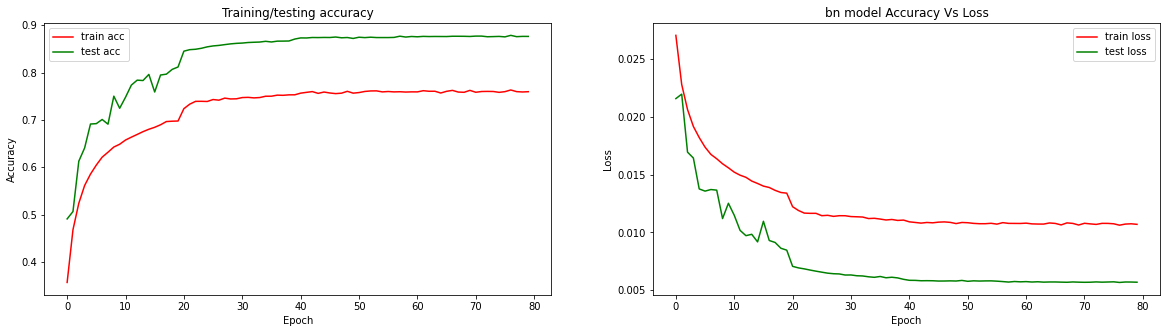

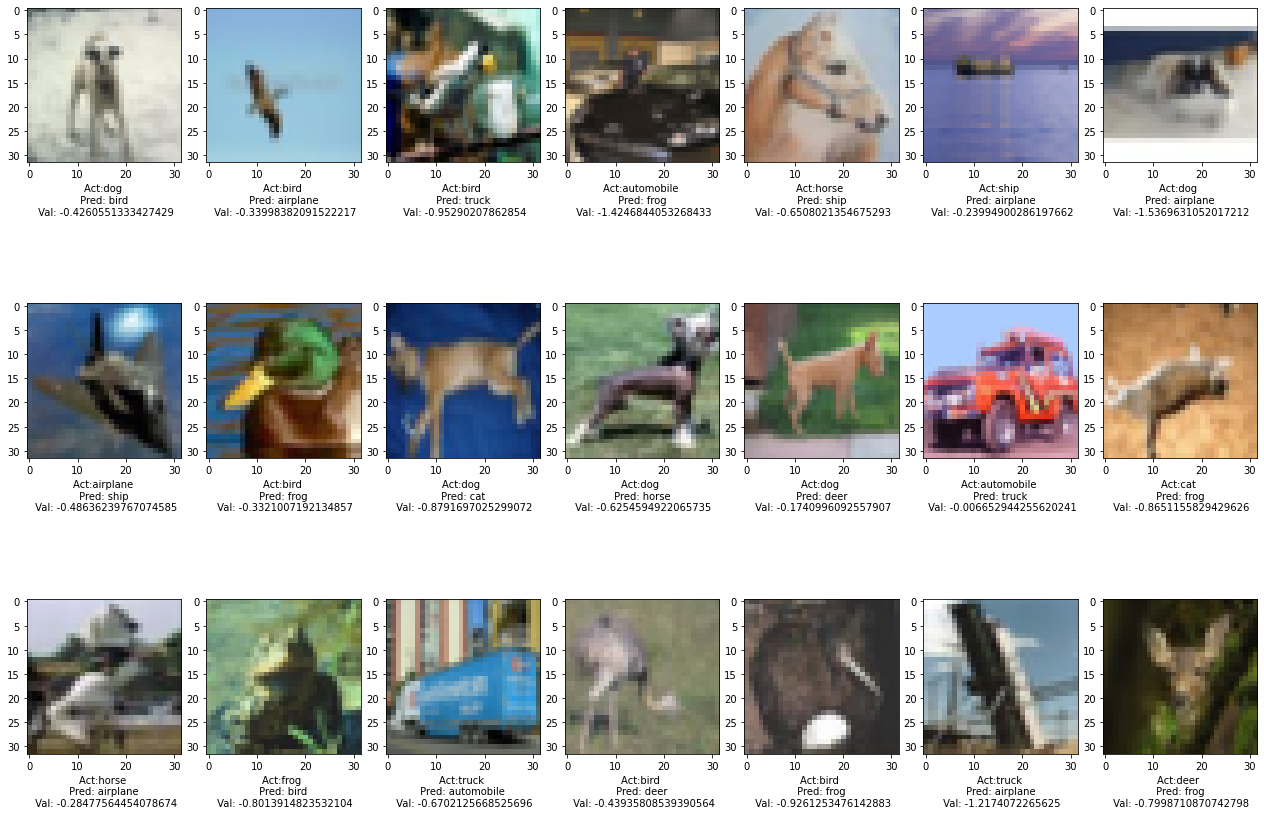

In [185]:
if __name__ == "__main__":
    batch_size = 64
    epochs = 80

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']
    # To Un Normalize the test data
    mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)

    train_alb = AlbumDataset(train,train_transform)
    test_alb = AlbumDataset(test,test_transform)

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['bn']
    for norm_type in try_type:

        model_class = Cifar10Net1(dropout_val=0.00,norm_type=norm_type)
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_alb,test_alb,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()

        print_wrong_image(model,test_loader,mean,std,3,7)
        clean_gpu()

In [185]:
CIFAR10_dialated_conv_depthwise_sep__Bnv2.ipynb